In [1]:
import os
cwd = os.getcwd()
jaxqualin_path = os.path.join(cwd, os.pardir, os.pardir)

In [2]:
import sys
sys.path.insert(0, jaxqualin_path)

In [3]:
import postprocess
import plot
import QuasinormalMode
import spheroidal

from postprocess import *
from plot import *
from QuasinormalMode import *
from spheroidal import *

2023-09-01 09:34:36.803945: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2023-09-01 09:34:36.845223: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2023-09-01 09:34:36.848172: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIB

In [4]:
from importlib import reload

In [5]:
reload(postprocess)
from postprocess import *
reload(plot)
from plot import *
reload(QuasinormalMode) 
from QuasinormalMode import *
reload(spheroidal)
from spheroidal import *

In [6]:
import pandas as pd
from matplotlib import ticker 

In [7]:
df_weak = pd.read_csv(f"../../pickle/data_frame/weak2_prodB1.csv")
df_normal = pd.read_csv(f"../../pickle/data_frame/normal2_prodB1.csv")
df_strong = pd.read_csv(f"../../pickle/data_frame/strong2_prodB1.csv")

In [8]:
df_weak_normal = df_weak.merge(df_normal, how = "inner",
                                on = ['SXS_num', 'M_rem',
                                      'chi_rem', 'chi_1_z',
                                      'chi_2_z', 'q', 'l', 'm', 
                                      'retro', 'mode_string'],
                              suffixes=('_1', '_2'))
df_normal_strong = df_normal.merge(df_strong, how = "inner",
                                on = ['SXS_num', 'M_rem',
                                      'chi_rem', 'chi_1_z',
                                      'chi_2_z', 'q', 'l', 'm', 
                                      'retro', 'mode_string'],
                              suffixes=('_1', '_2'))
df_weak_strong = df_weak.merge(df_strong, how = "inner",
                                on = ['SXS_num', 'M_rem',
                                      'chi_rem', 'chi_1_z',
                                      'chi_2_z', 'q', 'l', 'm', 
                                      'retro', 'mode_string'],
                              suffixes=('_1', '_2'))
                              

In [9]:
def string_replace(string):
    if string == 'constant':
        return string
    return r'$' + string.replace('.', r'{,}').replace('-', '\! - \!').replace('x', r'\! \times \!') + r'$'

In [10]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

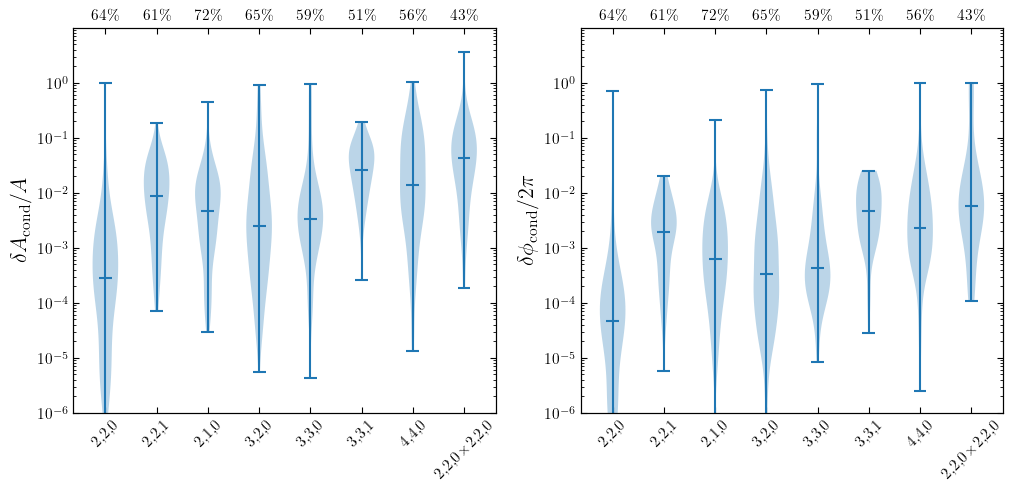

In [12]:
setting_low = "weak"
setting_hi = "normal"
# setting_low = "normal"
# setting_hi = "strong"

if setting_low == 'weak' and setting_hi == 'strong':
    df_in = df_weak_strong
elif setting_low == 'weak' and setting_hi == 'normal':
    df_in = df_weak_normal
elif setting_low == 'normal' and setting_hi == 'strong':
    df_in = df_normal_strong
else:
    raise ValueError

compare_list = [(2, 2, '2.2.0'), (2, 2, '2.2.1'), 
                (2, 1, '2.1.0'), (3, 2, '3.2.0'),
                (3, 3, "3.3.0"), (3, 3, '3.3.1'),
                (4, 4, "4.4.0"), 
                (4, 4, "2.2.0x2.2.0")]

fig, axs = plt.subplots(1,2, figsize = (12, 5))

ds_A = []
ds_phi = []
mode_strings = []
mode_zero_frac = []

for l, m, pro_mode_string in compare_list:

    retro_mode_string = qnm_string_m_reverse(pro_mode_string)

    df_compare = df_in[((df_in['l'] == l) & (df_in['m'] == m) & (df_in['mode_string'] == pro_mode_string)
                        & (df_in['retro'] == False)) |
                        ((df_in['l'] == l) & (df_in['m'] == m) & (df_in['mode_string'] == retro_mode_string)
                        & (df_in['retro'] == True))  ]

    A_1 = df_compare['A_med_1'].to_numpy()
    A_2 = df_compare['A_med_2'].to_numpy()
    phi_1 = df_compare['phi_med_1'].to_numpy()    
    phi_2 = df_compare['phi_med_2'].to_numpy()
    
    A_delta = np.abs((A_2 - A_1)/A_1)
    A_delta_nonzero = A_delta[A_delta != 0]
    zero_count = len(A_delta) - len(A_delta_nonzero)
    phi_delta = np.minimum(np.abs((phi_2%(2*np.pi) - phi_1%(2*np.pi))/(2*np.pi)),
                    (2*np.pi - np.abs((phi_2%(2*np.pi) - phi_1%(2*np.pi)))/(2*np.pi)))
    phi_delta_nonzero = phi_delta[phi_delta != 0]

    ds_A.append(np.log10(A_delta_nonzero))
    ds_phi.append(np.log10(phi_delta_nonzero))
    tex_mode_string = string_replace(pro_mode_string)
    zero_frac_percent_string = f"${int((1-zero_count/len(A_delta))*100)} \% $"
    mode_zero_frac.append(zero_frac_percent_string)
    mode_strings.append(tex_mode_string)

    # label the percentage of count that is zero on the bottom of each violin with an arrow pointing downwards
    # axs[0].annotate(f"{zero_count/len(A_delta):.0%}", xy=(pro_mode_string, -0.1), xytext=(0, -20),
    #             textcoords="offset points", ha='center', va='bottom',
    #             arrowprops=dict(arrowstyle="->", shrinkA=0))

    # ax.scatter([pro_mode_string] * len(A_delta_nonzero), A_delta_nonzero, alpha = 0.1)
axs[0].violinplot(ds_A, showextrema=True, showmedians=True, points = 100)
axs[1].violinplot(ds_phi, showextrema=True, showmedians=True, points = 100)
axs0 = axs[0].twiny()
axs1 = axs[1].twiny()
parts0 = axs0.violinplot(ds_A, showextrema=False, showmedians=False, points = 100)
parts1 = axs1.violinplot(ds_phi, showextrema=False, showmedians=False, points = 100)
for part in (parts0, parts1):
    for pc in part['bodies']:
        pc.set_alpha(0) 

for ax, ax0 in zip(axs, (axs0, axs1)):
    ax.set_ylim(-6, 1)
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
    ymin, ymax = ax.get_ylim()
    tick_range = np.arange(np.floor(ymin), ymax)
    ax.yaxis.set_ticks(tick_range)
    ax.yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)

    ax.set_xticks(list(range(1, len(compare_list) + 1)))
    # xtick = ax.get_xticks()
    ax0.set_xticks(list(range(1, len(compare_list) + 1)))
    # axs0.set_xticks(xtick)
    ax0.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax0.set_xticklabels(mode_zero_frac)
    ax.set_xticklabels(mode_strings)
    ax.tick_params('x', rotation = 45)
    
axs[0].set_ylabel(r"$\delta A_{\rm cond} / A$", fontsize = 16)
axs[1].set_ylabel(r"$\delta \phi_{\rm cond} / 2 \pi$", fontsize = 16)

# fig.suptitle(f"{setting_low} vs {setting_hi} requirement", fontsize = 18)
plt.savefig(f"../../plots/prod_{setting_low}_vs_{setting_hi}.pdf", bbox_inches = "tight")
# plt.savefig(PLOT_PATH_ROOT + f"{setting_low}_vs_{setting_hi}.png", dpi = 150, bbox_inches = "tight",
#         facecolor='white', transparent=False)